# Credit Card Fraud Detection
This notebook performs data exploration, modeling, and interpretation for detecting fraudulent transactions using a Decision Tree. We address class imbalance and apply model explainability tools such as PDP and ALE.

In [7]:
# !pip install alibi

# Then import and use for ALE plots
# from alibi.explainers import ALE, plot_ale

In [8]:
# pip install lime

## 1. Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# For explainability
from sklearn.inspection import PartialDependenceDisplay
import shap
# from alepython import ale_plot
%matplotlib inline

## 2. Load and Inspect Data

In [10]:
df = pd.read_csv('/content/creditcard.csv')
df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

Target "class" 1 in case of fraud and 0 otherwise.

In [11]:
print(df.shape)


(284807, 31)


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## 3. Exploratory Data Analysis (EDA)

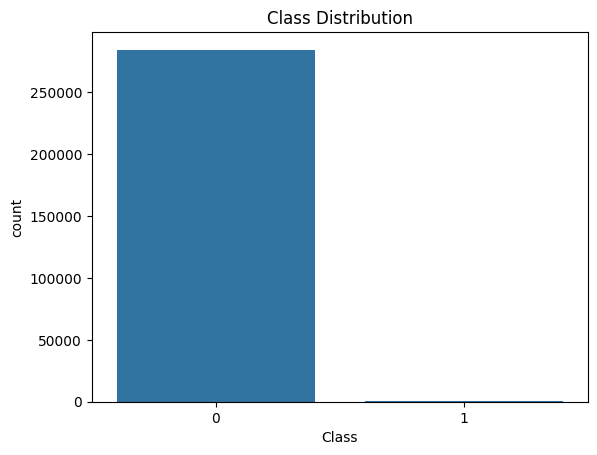

Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [13]:
sns.countplot(data=df, x='Class')
plt.title('Class Distribution')
plt.show()

print(df['Class'].value_counts(normalize=True) * 100)

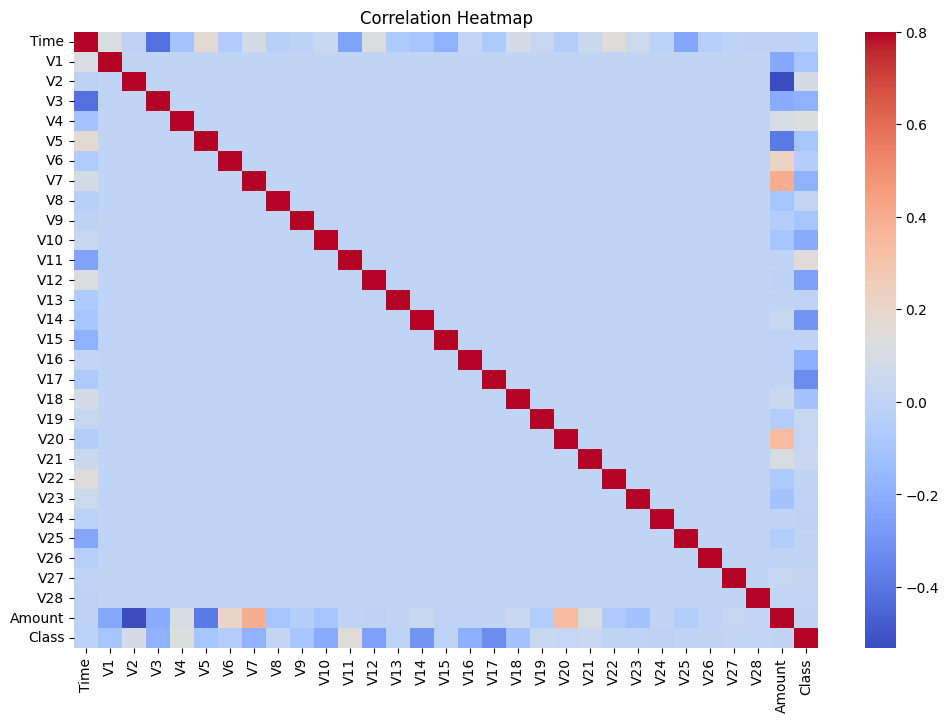

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), cmap='coolwarm', vmax=0.8)
plt.title('Correlation Heatmap')
plt.show()

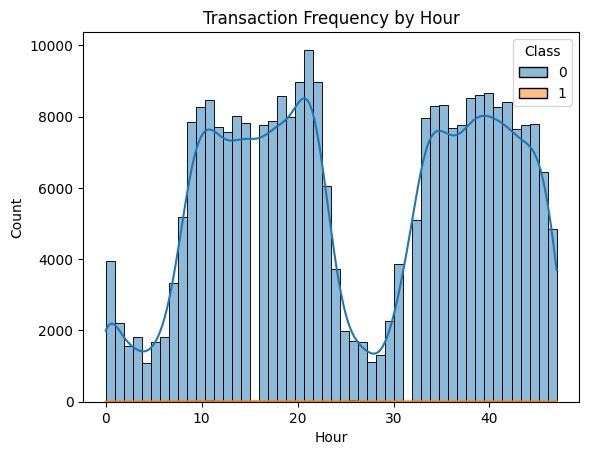

In [15]:
df['Hour'] = df['Time'] // 3600
sns.histplot(data=df, x='Hour', hue='Class', bins=50, kde=True)
plt.title("Transaction Frequency by Hour")
plt.show()

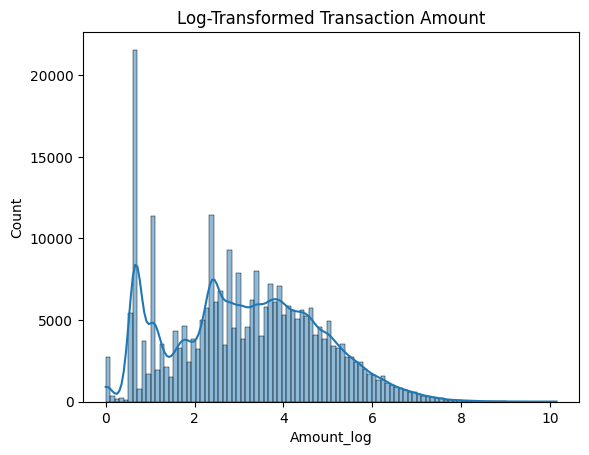

In [16]:
df['Amount_log'] = np.log1p(df['Amount'])
sns.histplot(df['Amount_log'], bins=100, kde=True)
plt.title('Log-Transformed Transaction Amount')
plt.show()

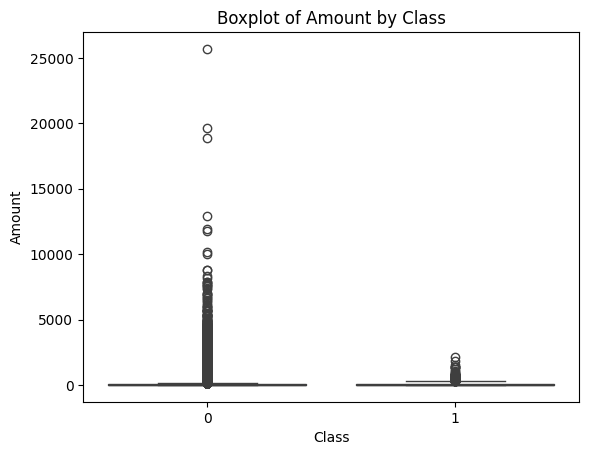

In [17]:
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Boxplot of Amount by Class')
plt.show()

## 4. Preprocessing and Balancing with SMOTE

In [18]:
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)

print("After SMOTE:")
print(pd.Series(y_res).value_counts())

After SMOTE:
Class
0    284315
1    284315
Name: count, dtype: int64


## 5. Train-Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

## 6. Decision Tree Training and Evaluation

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     85149
           1       0.97      0.96      0.97     85440

    accuracy                           0.97    170589
   macro avg       0.97      0.97      0.97    170589
weighted avg       0.97      0.97      0.97    170589



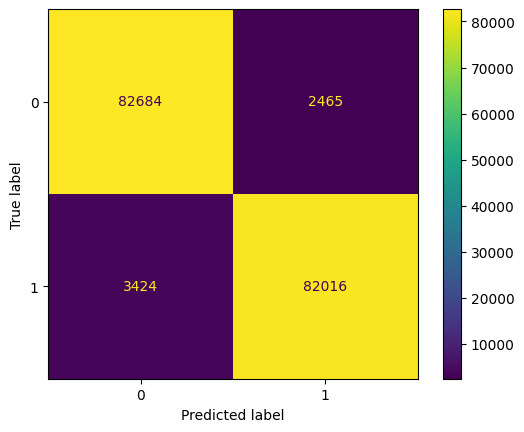

In [20]:
model = DecisionTreeClassifier(max_depth=6, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

## Learning Curve

In [21]:
from sklearn.model_selection import learning_curve

In [22]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='orange')
    plt.title('Learning Curve')
    plt.xlabel('Training Size')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

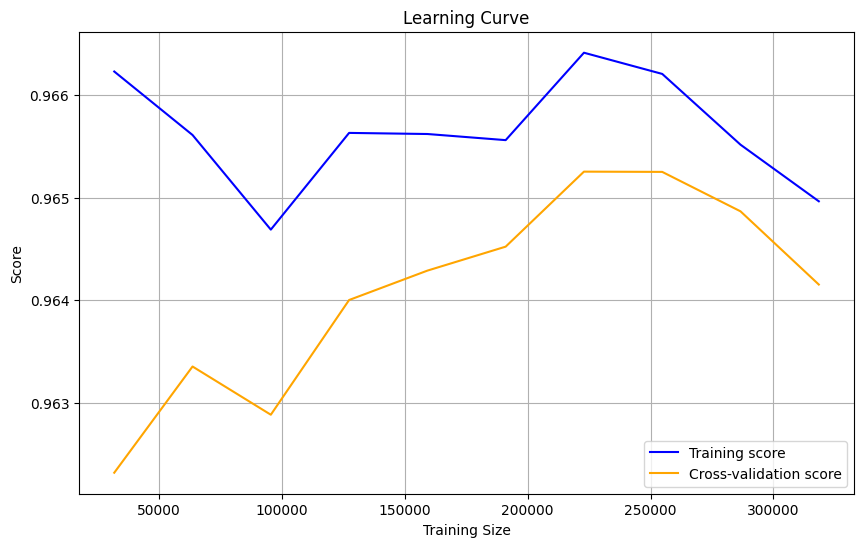

In [23]:
plot_learning_curve(model, X_train, y_train)

## Validation Curve

In [24]:
from sklearn.model_selection import validation_curve

In [25]:
def plot_validation_curve(model, X, y, param_name, param_range):
    train_scores, test_scores = validation_curve(
        model, X, y, param_name=param_name, param_range=param_range, cv=5, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, train_scores_mean, label='Training score', color='blue')
    plt.plot(param_range, test_scores_mean, label='Cross-validation score', color='orange')
    plt.title('Validation Curve')
    plt.xlabel(param_name)
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
param_range = np.arange(1, 11)

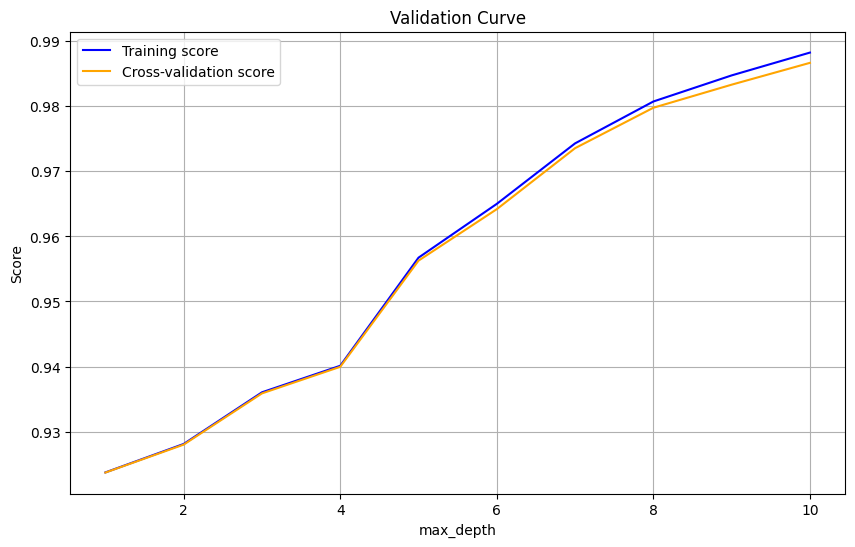

In [27]:
plot_validation_curve(model, X_train, y_train, param_name='max_depth', param_range=param_range)

## 7. Model Explainability with PDP (Partial Dependence Plots)

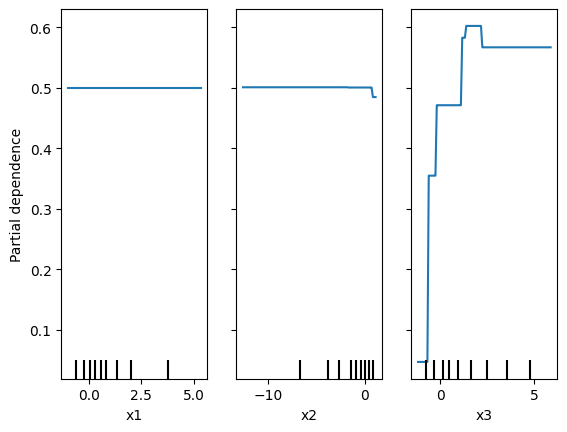

In [28]:
features = [1, 2, 3]
PartialDependenceDisplay.from_estimator(model, X_train, features)
plt.show()

ICE Plot


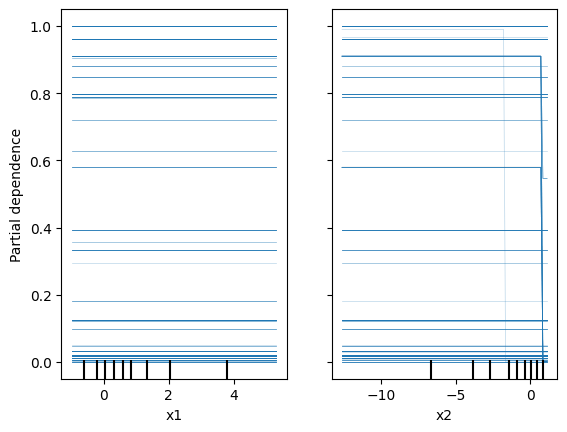

In [29]:
features = [1,2]
PartialDependenceDisplay.from_estimator(model, X_train, features,kind='individual')
plt.show()

## 8. SHAP (SHapley Additive exPlanations)

<Figure size 640x480 with 0 Axes>

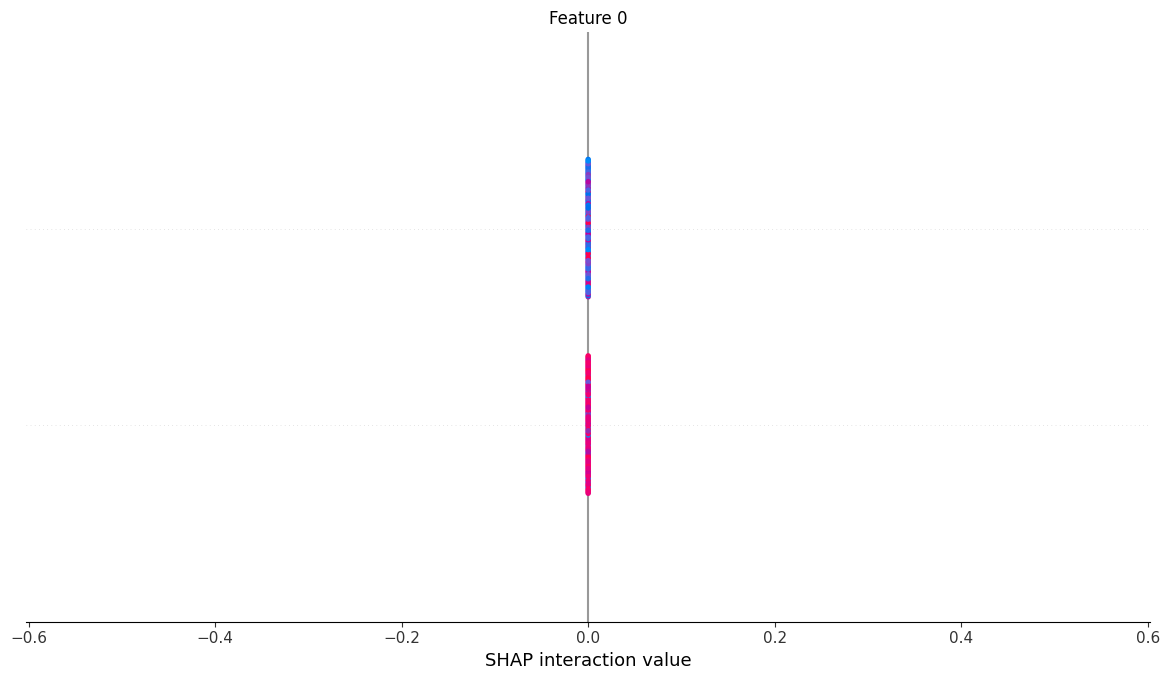

In [30]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test[:100])

shap.summary_plot(shap_values, X_test[:100])

## 9. ALE (Accumulated Local Effects)

In [31]:
# ale_plot(model, X=pd.DataFrame(X_train, columns=df.drop(['Class', 'Time'], axis=1).columns), feature='V10', bins=20)

# identify relationships among features:

## 10. Local Explanation with LIME (Local Interpretable Model-agnostic Explanations)
We use LIME to explain predictions for individual instances, both fraud and non-fraud.

In [32]:
# pip install lime

In [33]:
import lime
import lime.lime_tabular

# Create explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train,
    feature_names=df.drop(['Class', 'Time'], axis=1).columns.tolist(),
    class_names=['Not Fraud', 'Fraud'],
    mode='classification'
)

# Choose fraud and non-fraud examples
fraud_idx = np.where(y_test == 1)[0][0]
nonfraud_idx = np.where(y_test == 0)[0][0]

# Explain prediction for fraud
print("Explanation for Fraud Case:")
exp_fraud = explainer.explain_instance(X_test[fraud_idx], model.predict_proba)
exp_fraud.show_in_notebook(show_table=True)

# Explain prediction for non-fraud
print("Explanation for Non-Fraud Case:")
exp_nonfraud = explainer.explain_instance(X_test[nonfraud_idx], model.predict_proba)
exp_nonfraud.show_in_notebook(show_table=True)

Explanation for Fraud Case:


Explanation for Non-Fraud Case:
